In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import re
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#upload resons and calls data

calls_df = pd.read_csv('/content/reasons.csv')
reasons_df = pd.read_csv('/content/calls.csv')
merged_df = pd.merge(calls_df, reasons_df, on='call_id')

def preprocess_text(text):
    filler_words = ['uhh', 'umm', 'yeah', 'okay', 'alright', 'like', 'you know','agent','customer','know','really','rest','high','help','let','look','pull','hi','thanks','youre','typing']
    text = ' '.join(word for word in text.split() if word.lower() not in filler_words)

    agent_phrases = [
        r'thank you for calling united airlines customer service.*?',
        r'thank you for your patience.*?',
        r'(my name is .*? how may i help you\?)',
        r'(thank you for flying with us.*)'
    ]
    for phrase in agent_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)

    contractions = {"don't": "do not", "can't": "cannot", "i'm": "i am", "it's": "it is", "isn't": "is not"}
    for contraction, full_form in contractions.items():
        text = re.sub(contraction, full_form, text, flags=re.IGNORECASE)

    text = re.sub(r'[^a-zA-Z\s\?\!]', '', text)
    text = text.lower()

    domain_specific_stopwords = ['flight', 'airline', 'reservation', 'book', 'united']
    all_stopwords = stop_words.union(domain_specific_stopwords)
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split() if word not in all_stopwords)

    return text

merged_df['cleaned_transcript'] = merged_df['call_transcript'].apply(preprocess_text)

merged_df['primary_call_reason'] = (
    merged_df['primary_call_reason']
    .str.strip()
    .str.lower()
    .str.replace(r'\s+', ' ', regex=True)
)

X = merged_df['cleaned_transcript']
y = merged_df['primary_call_reason']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

model = RandomForestClassifier(class_weight=class_weights, n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

misclassifications = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(misclassifications[misclassifications['Actual'] != misclassifications['Predicted']])

def predict_call_reason(transcript):
    """Predict the primary call reason for a given transcript."""
    cleaned_transcript = preprocess_text(transcript)

    transcript_tfidf = vectorizer.transform([cleaned_transcript])

    prediction = model.predict(transcript_tfidf)

    return prediction[0]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[[   0    0    0    0    0    0    0    0    0  484    2    0    0    0
     0    0    0    5    0    0    0    0  113]
 [   0    0    0    0    0    0    0    0    0  399    1    0    0    0
     0    0    0    7    0    0    0    0  106]
 [   0    0    0    0    0    0    0    0    0   61    0    0    0    0
     0    0    0    0    0    0    0    0   15]
 [   0    0    0    0    0    0    0    0    0  215    1    0    0    1
     0    0    0    3    0    0    0    0   63]
 [   0    0    0    0    0    0    0    0    0  300    3    0    0    0
     0    0    0    3    0    0    0    0   78]
 [   0    0    0    0    0    0    0    0    0  595    5    0    0    0
     0    0    0    6    0    0    0    0  151]
 [   0    0    0    0    0    0    0    0    0  206    0    0    0    0
     0    0    0    3    0    0    0    0   46]
 [   0    0    0    0    0    0    0    0    0   60    0    0    0    0
     0    0    0    1    0    0    0    0   25]
 [   0    0    0    0    0    0    0    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score   support

              baggage       0.00      0.00      0.00       604
              booking       0.00      0.00      0.00       513
             check in       0.00      0.00      0.00        76
             check-in       0.00      0.00      0.00       283
             checkout       0.00      0.00      0.00       384
       communications       0.00      0.00      0.00       757
      digital support       0.00      0.00      0.00       255
           disability       0.00      0.00      0.00        86
                  etc       0.00      0.00      0.00       197
               irrops       0.21      0.83      0.34      2763
         mileage plus       0.03      0.00      0.00      1130
         other topics       0.00      0.00      0.00       174
          post flight       0.00      0.00      0.00        75
          post-flight       0.00      0.00      0.00       773
  products & services       0.00      0.00      0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


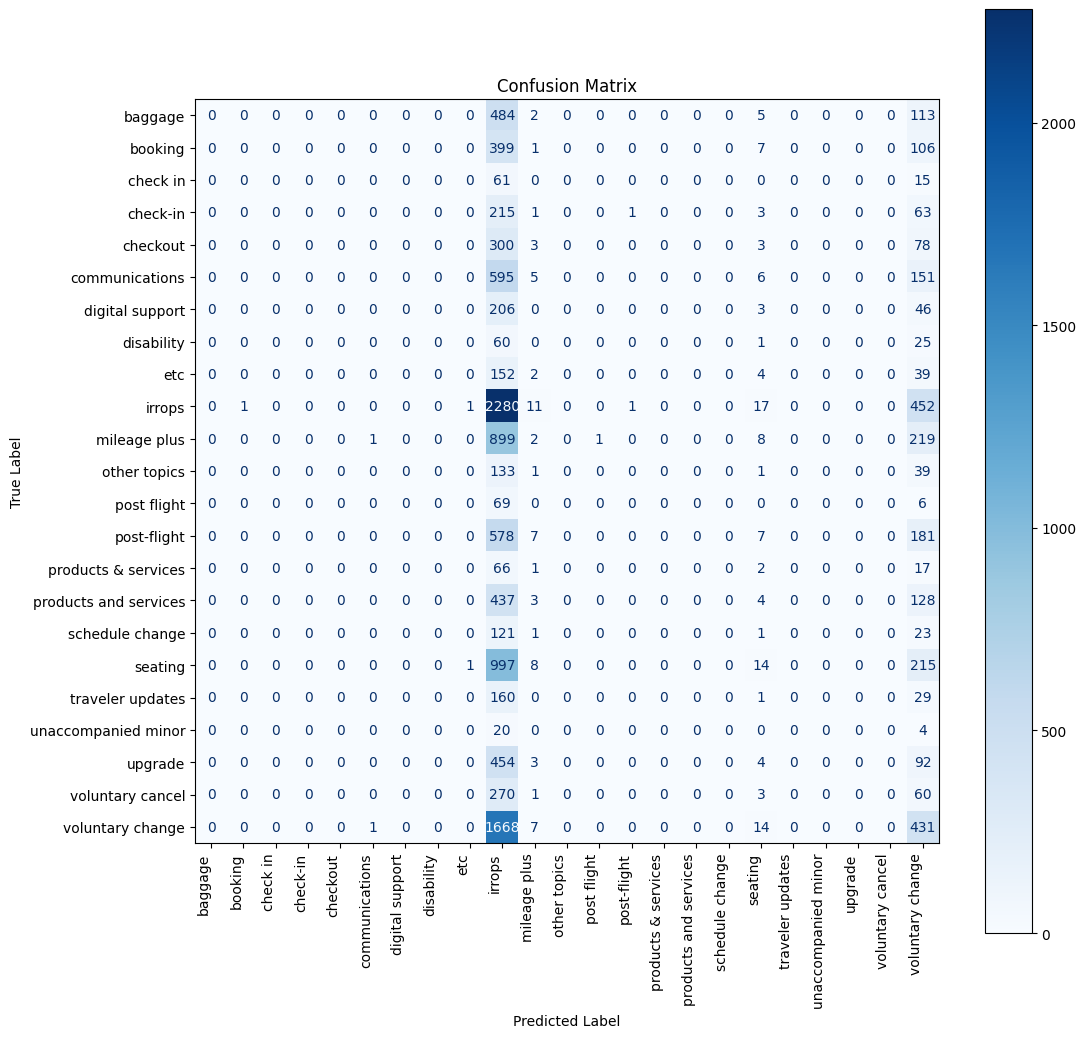

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12, 12))
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.xticks(rotation=90, ha='right')

plt.show()

In [33]:
transcript = "Thank you for calling United Airlines, I want to change my flight."
predicted_reason = predict_call_reason(transcript)
print("Predicted Call Reason:", predicted_reason)

Predicted Call Reason: upgrade


In [39]:
transcript_2 = "\n\nAgent: Thank you for calling United Airlines customer service, my name is Sarah how may I help you?\n\nCustomer: Hi, yeah I'm calling because my flight from Chicago to New York was delayed by over 3 hours! This is ridiculous, I'm missing important meetings because of this. \n\nAgent: I'm so sorry to hear about the delay, that's definitely frustrating. Umm, let me pull up your reservation and take a look at what happened. *typing sounds* Okay, it looks like there was severe weather in Chicago that caused multiple flight cancellations and delays across the board for all the airlines. Ahh shoot, yeah your original flight was scheduled to depart at 2pm but didn't actually take off until after 5pm.\n\nCustomer: Ugh this is such poor planning on United's part, you should have rerouted passengers or put us on other flights that weren't delayed. Now I've wasted a whole day. \n\nAgent: I understand your frustration sir, delays are never fun. Let me see what options I have available to help make this up to you. Hmm, it looks like I can get you booked on a flight leaving at 3pm tomorrow that will have you landing in New York by 5pm. I'll waive the change fee and provide you with a travel voucher for $200 to help cover expenses from the missed meetings today. Does that work for your schedule?\n\nCustomer: I guess that's better than nothing. But you really need to get your act together, this is unacceptable customer service from United. Your delays are costing people time and money. \n\nAgent: You're right, we want to do better for our customers. I apologize again for the delay and inconvenience. Thank you for flying with us and I hope the rescheduled flight and travel credit help make up for some of the trouble today. Please feel free to reach back out if you have any other issues. Thanks for your patience and for understanding - I appreciate you taking the time to work through this with me.\n\nCustomer: Alright fine. This better not happen again next time I fly United. \n\nAgent: I'll be sure to note your record so we can try and avoid any repeats going forward. Take care and have a good rest of your day.\n\nCustomer: Yeah, you too. *hangs up*\n\nAgent: Thank you for your call, next caller please. *pretends to answer another call* Hi there, thank you for calling United how can I help?"

predicted_reason = predict_call_reason(transcript_2)
print("Predicted Call Reason:", predicted_reason)

Predicted Call Reason: voluntary cancel


In [45]:
calls_df['primary_call_reason'][0]

'Voluntary  Cancel'